# Simpsons Classifier


## Images with different sizes: understanding _Spatial Pyramid Pooling_

If the neural network has a fixed size as input images we'll have to deal with it. 

So the possible solutions will be:

* Crop: problem, there is information that gets lost.
* Warp/Resize: problem, the image patterns change and we lose accuracy.
* Padding: problem, the model might be biased to images that contain such a padded border.
* Combination of previous.

Spatial Pyramid Pooling tries to resolve it. Indeed it should improve the efficiency.

Paper: https://arxiv.org/abs/1406.4729

### Obtaining the Dataset

In [2]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!echo '{"username":"XXXX","key":"XXXX"}' > ~/.kaggle/kaggle.json
!kaggle datasets download -d alexattia/the-simpsons-characters-dataset

100%|█████████████████████████████████████▊| 1.06G/1.07G [00:09<00:00, 66.7MB/s]
100%|███████████████████████████████████████| 1.07G/1.07G [00:09<00:00, 115MB/s]


In [0]:
!unzip -qo the-simpsons-characters-dataset.zip -d the-simpsons-characters-dataset
!unzip -qo ./the-simpsons-characters-dataset/simpsons_dataset.zip -d the-simpsons-characters-dataset/
!unzip -qo ./the-simpsons-characters-dataset/kaggle_simpson_testset.zip -d the-simpsons-characters-dataset/

!rm ./the-simpsons-characters-dataset/kaggle_simpson_testset/.DS_Store
!rm ./the-simpsons-characters-dataset/simpsons_dataset/nelson_muntz/.DS_Store

In [10]:
from os import listdir

#configure train dataset
train_root_path = "./the-simpsons-characters-dataset/simpsons_dataset"
character_directories = listdir(train_root_path)
#character_directories.remove('.DS_Store')
print("Train: {}".format(character_directories[:5]))

#configure test dataset
test_root_path = "./the-simpsons-characters-dataset/kaggle_simpson_testset"
test_image_names = listdir(test_root_path)
#test_image_names.remove('.DS_Store')
print("Test: {}".format(test_image_names[:5]))

Train: ['abraham_grampa_simpson', 'moe_szyslak', 'kent_brockman', 'lionel_hutz', 'barney_gumble']
Test: ['kent_brockman_33.jpg', 'homer_simpson_17.jpg', 'lisa_simpson_7.jpg', 'marge_simpson_38.jpg', 'principal_skinner_48.jpg']


## Defining Datasets

In [3]:
# If running in Google Colab
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl torchvision
import torch
print(torch.__version__)
print(torch.cuda.is_available())

tcmalloc: large alloc 1073750016 bytes == 0x5c8ec000 @  0x7fc7d5a6b1c4 0x46d6a4 0x5fcbcc 0x4c494d 0x54f3c4 0x553aaf 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54e4c8
0.4.0
True


In [0]:
#Import libraries
import os
import glob
import random
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.misc import imread, imresize
from random import shuffle
#from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [15]:
#Initial data inside simpsons.tar.gz
info = pd.read_csv('./the-simpsons-characters-dataset-MEDIUM/number_pic_char.csv')
print(info)

    Unnamed: 0                      name  total  train  test  bounding_box
0            0             Homer Simpson   2246   1909   337           612
1            1              Ned Flanders   1454   1236   218           595
2            2               Moe Szyslak   1452   1234   218           215
3            3              Lisa Simpson   1354   1151   203           562
4            4              Bart Simpson   1342   1141   201           554
5            5             Marge Simpson   1291   1097   194           557
6            6          Krusty The Clown   1206   1025   181           226
7            7         Principal Skinner   1194   1015   179           506
8            8  Charles Montgomery Burns   1193   1014   179           650
9            9       Milhouse Van Houten   1079    917   162           210
10          10              Chief Wiggum    986    838   148           209
11          11    Abraham Grampa Simpson    913    776   137           595
12          12           

In [0]:
def get_character_directories(path):
    character_directories = os.listdir(path)
    if '.DS_Store' in character_directories: character_directories.remove('.DS_Store')
    return character_directories

def get_images_from_directory(path):
    image_files = os.listdir(path)
    if '.DS_Store' in image_files: image_files.remove('.DS_Store')
    return image_files

In [0]:
#root pats
train_root_path = "./the-simpsons-characters-dataset-MEDIUM/simpsons_dataset"
test_root_path = "./the-simpsons-characters-dataset-MEDIUM/kaggle_simpson_testset"

#train directories
character_directories = get_character_directories(train_root_path)

In [7]:
def test_paths():
    #configure train dataset
    print("Train: {}".format(character_directories[:5]))

    #images from one train directory
    character_path = train_root_path + "/" + character_directories[1]
    train_image_names = get_images_from_directory(character_path)
    print("Images of {}: {}".format(character_directories[1], train_image_names[:5]))


    #configure test dataset
    test_image_names = get_images_from_directory(test_root_path)
    print("\nTest: {}".format(test_image_names[:5]))

test_paths()

Train: ['moe_szyslak', 'disco_stu', 'jimbo_jones', 'fat_tony', 'miss_hoover']
Images of disco_stu: ['pic_0005.jpg', 'pic_0006.jpg', 'pic_0002.jpg', 'pic_0000.jpg', 'pic_0003.jpg']

Test: ['mayor_quimby_43.jpg', 'bart_simpson_15.jpg', 'abraham_grampa_simpson_13.jpg', 'milhouse_van_houten_14.jpg', 'krusty_the_clown_5.jpg']


### Showing Training and Test Samples

In [0]:
def plot_image(image):
    plt.figure(figsize=(3, 3))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

Label:ned_flanders, Image:7, Shape:(120, 160, 3)


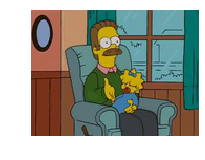

In [9]:
def show_train_image(character_directory, idx):
    directory = os.path.join(train_root_path, character_directory)
    sample_file = get_images_from_directory(directory)[idx]
    path_file = os.path.join(directory, sample_file)
    sample_image = imread(path_file)

    print("Label:{}, Image:{}, Shape:{}".format(character_directory, idx, sample_image.shape))
    plot_image(sample_image)
    
idx = random.randint(0, 10)
show_train_image(character_directories[idx], idx)

Label:bart_simpson, Image:1, Shape:(77, 52, 3)


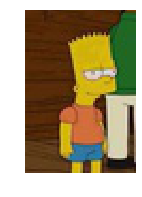

In [10]:
def show_test_image(idx):
    test_image_names = get_images_from_directory(test_root_path)
    sample_file, sample_name = test_image_names[idx], test_image_names[idx].split('_')[:-1]
    path_file = os.path.join(test_root_path, sample_file)
    sample_image = imread(path_file)

    print("Label:{}, Image:{}, Shape:{}".format('_'.join(sample_name), idx, sample_image.shape))
    plot_image(sample_image)

idx = random.randint(0, 10)
show_test_image(idx)

### Training Images

In [0]:
'''
Input 'different_characters' will define the number of different Simpson
characters the generator is going to return

@Return: tuple (images list, names list)
'''
#Create the batch generator
def batch_generator_training_images(batch_size, different_characters, verbose=False):
    #Obtain the characters Serie with the most number of images
    characters = info.sort_values(by='total', ascending=False).name

    #transform to list with the following format:  Homer Simpson -> homer_simpson
    characters = characters.map(lambda x: x.replace(" ", "_").lower()).tolist()

    path_name_list = list()
    for i in range(0, different_characters):
        directory = os.path.join(train_root_path, characters[i])
        path_name_list += list(map( lambda x: (os.path.join(directory, x), characters[i]), 
                                    get_images_from_directory(directory)))

    #shuffle all the images
    shuffle(path_name_list)
    
    #getting a number of complete chunks according to the batch size
    number_complete_chunks = len(path_name_list)//batch_size
    num_images_in_all_chunks = number_complete_chunks * batch_size
        
    for b in range(0, num_images_in_all_chunks, batch_size):
        if verbose:
            print("init: {}, end:{}".format(b, b+batch_size))
        
        yield (list(map( lambda x: imread(x[0]), path_name_list[b:b + batch_size])), #x == path
               list(map( lambda x: x[1], path_name_list[b:b + batch_size])) ) #x == name


init: 0, end:32
krusty_the_clown


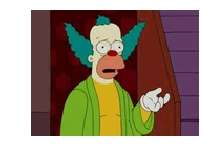

In [12]:
#testing how to show an image from generator
def testing_generator_1():
    for batch in batch_generator_training_images(32, 10, True):
        for img, name in zip(*batch):
            print(name)
            plot_image(img)
            break
        pass
        break
        
testing_generator_1()

In [13]:
#testing the generator
def testing_generator_2():
    group = {}

    for batch in batch_generator_training_images(8, 10, True):
        for img, name in zip(*batch):
            if not img.shape in group:
                group[img.shape] = []
            group[img.shape].append(img)
        pass
        break

    for key, lists in group.items():
        print("shape{} count:{}".format(key, len(lists)))


testing_generator_2()

init: 0, end:8
shape(108, 144, 3) count:2
shape(108, 72, 3) count:3
shape(100, 68, 3) count:1
shape(96, 128, 3) count:2


In [0]:
#global variable
num_classes = 10 #different number of Simpons characters

In [0]:
#one hot encoder
lb = preprocessing.LabelBinarizer()

def customize_onehot_encoder(num_classes=10):
    #Obtain the characters Serie with the most number of images
    characters = info.sort_values(by='total', ascending=False).name

    #transform to list with the following format:  Homer Simpson -> homer_simpson
    names = characters[:num_classes].map(lambda x: x.replace(" ", "_").lower()).tolist()

    print("Character classes: {}\n".format(names))
    lb.fit(names)


### Storing Processed Files On Disk

In [0]:
#global variable
file_prefix = "spp_simpson_train_"
batch_size = 1024

In [17]:
def create_processed_files(batch_size=64):
    customize_onehot_encoder(num_classes)
    # Format of data => {shape: {'images':[], 'labels':[]} }
    data = {}
    
    '''
    The batch generator returns a tuple of two lists!!! (list_images, list_names)
    '''
    for cnt, batch in enumerate(batch_generator_training_images(batch_size, num_classes)):
                
        #group by shape
        grouped = {}
        for image, name in zip(*batch):
            if not image.shape in grouped:
                grouped[image.shape] = []
            grouped[image.shape].append((image, name))        
        
        #training images which are grouped by shape at the same time
        for shape, tuple_imagesList_namesList in grouped.items():
            imagesList, namesList = zip(*tuple_imagesList_namesList)
            
            #casting
            images = np.array(imagesList)
            #onehot encoding names
            names = np.array(lb.transform(namesList))
            
            if len(shape) == 3: #just in case dimension are less than 3
                #print("Storing shape:{} with {}".format(shape, len(images)))
                data[shape] = {'images': images, 'labels': names}
            else:
                print("W: Dim image < 3")
        
        #save into disk
        with open("{}{}.pkl".format(file_prefix, cnt), 'wb') as file:
            pickle.dump(data, file, pickle.HIGHEST_PROTOCOL)
            print("{} saved".format("{}{}.pkl".format(file_prefix, cnt)))
        

create_processed_files(batch_size)

Character classes: ['homer_simpson', 'ned_flanders', 'moe_szyslak', 'lisa_simpson', 'bart_simpson', 'marge_simpson', 'krusty_the_clown', 'principal_skinner', 'charles_montgomery_burns', 'milhouse_van_houten']

spp_simpson_train_0.pkl saved
spp_simpson_train_1.pkl saved
spp_simpson_train_2.pkl saved
W: Dim image < 3
spp_simpson_train_3.pkl saved
spp_simpson_train_4.pkl saved
spp_simpson_train_5.pkl saved
spp_simpson_train_6.pkl saved
spp_simpson_train_7.pkl saved
spp_simpson_train_8.pkl saved
spp_simpson_train_9.pkl saved
spp_simpson_train_10.pkl saved
spp_simpson_train_11.pkl saved
spp_simpson_train_12.pkl saved


Since here, the images are processed and stored in different pickle files. 

The format of the __data is a dictionary__ which follows the format:  
```
{shape: {'images':[], 'labels':[]} }
```

## Keras + SPP Module

Keras doesn't support currently the SSP layer but thanks to [yhenon](https://github.com/yhenon) there's a module which is integrated into keras. [Code is here](https://github.com/yhenon/keras-spp)

In [18]:
!git clone https://github.com/yhenon/keras-spp.git
!cd keras-spp && python setup.py install


Cloning into 'keras-spp'...
remote: Counting objects: 125, done.
remote: Total 125 (delta 0), reused 0 (delta 0), pack-reused 125
Receiving objects: 100% (125/125), 29.25 KiB | 374.00 KiB/s, done.
Resolving deltas: 100% (76/76), done.
running install
running build
running build_py
creating build
creating build/lib
creating build/lib/spp
copying spp/__init__.py -> build/lib/spp
copying spp/RoiPooling.py -> build/lib/spp
copying spp/RoiPoolingConv.py -> build/lib/spp
copying spp/SpatialPyramidPooling.py -> build/lib/spp
running install_lib
creating /usr/local/lib/python3.6/dist-packages/spp
copying build/lib/spp/__init__.py -> /usr/local/lib/python3.6/dist-packages/spp
copying build/lib/spp/RoiPooling.py -> /usr/local/lib/python3.6/dist-packages/spp
copying build/lib/spp/RoiPoolingConv.py -> /usr/local/lib/python3.6/dist-packages/spp
copying build/lib/spp/SpatialPyramidPooling.py -> /usr/local/lib/python3.6/dist-packages/spp
byte-compiling /usr/local/lib/python3.6/dist-packages/spp/__ini

In [3]:
from keras.models import Sequential
from keras.layers import Conv2D, Convolution2D, Activation, MaxPooling2D, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from spp.SpatialPyramidPooling import SpatialPyramidPooling

Using TensorFlow backend.


In [0]:
from keras.engine.topology import Layer
import keras.backend as K


class SPP(Layer):
    """
    # Arguments
        pool_list: list of int
            List of pooling regions to use. The length of the list is the number of pooling regions,
            each int in the list is the number of regions in that pool. For example [1,2,4] would be 3
            regions with 1, 2x2 and 4x4 max pools, so 21 outputs per feature map
    # Input shape
        4D tensor with shape (samples, rows, cols, channels)
    # Output shape
        2D tensor with shape (samples, channels * sum([i * i for i in pool_list])
    """

    def __init__(self, pool_list, **kwargs):

        self.dim_ordering = K.image_dim_ordering()
        assert self.dim_ordering in {'tf'}, 'dim_ordering must be in tensorflow'

        self.pool_list = pool_list
        self.num_outputs_per_channel = sum([i * i for i in pool_list])
        super(SPP, self).__init__(**kwargs)

    def build(self, input_shape):
        self.nb_channels = input_shape[3]

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.nb_channels * self.num_outputs_per_channel)

    def get_config(self):
        config = {'pool_list': self.pool_list}
        base_config = super(SPP, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def call(self, x, mask=None):
        input_shape = K.shape(x)

        num_rows = input_shape[1]
        num_cols = input_shape[2]

        row_length = [K.cast(num_rows, 'float32') / i for i in self.pool_list]
        col_length = [K.cast(num_cols, 'float32') / i for i in self.pool_list]

        outputs = []

        for pool_num, num_pool_regions in enumerate(self.pool_list):
            for jy in range(num_pool_regions):
                for ix in range(num_pool_regions):
                    x1 = ix * col_length[pool_num]
                    x2 = ix * col_length[pool_num] + col_length[pool_num]
                    y1 = jy * row_length[pool_num]
                    y2 = jy * row_length[pool_num] + row_length[pool_num]

                    x1 = K.cast(K.round(x1), 'int32')
                    x2 = K.cast(K.round(x2), 'int32')
                    y1 = K.cast(K.round(y1), 'int32')
                    y2 = K.cast(K.round(y2), 'int32')

                    new_shape = [input_shape[0], y2 - y1,
                                 x2 - x1, input_shape[3]]

                    x_crop = x[:, y1:y2, x1:x2, :]
                    xm = K.reshape(x_crop, new_shape)
                    pooled_val = K.max(xm, axis=(1, 2))
                    outputs.append(pooled_val)

        #outputs = K.concatenate(outputs)
        outputs = K.reshape(outputs, self.compute_output_shape(input_shape))

        return outputs

In [48]:
'''
Build a model with a typical network architecture
'''
def build_model(num_channels = 3, num_classes = 10, filters = 32):
    model = Sequential()

    #Note: leave the image size as None to allow multiple image sizes
    model.add(Conv2D(filters, (3, 3), padding='same', input_shape=(None, None, num_channels)))
    model.add(Activation('relu'))
    model.add(Conv2D(filters, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    
    model.add(Conv2D(filters*2, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(filters*2, (3, 3)))
    model.add(Activation('relu'))
    
    #SPP
    model.add(SPP([1, 2, 3]))
    #for l in [1,2,4]:
    #    kernel_size = ceil(a/l)
    #    stride_size = floor(a/l)
    #    model.add(MaxPooling2D(pool_size=pool_size, strides=strides, padding='valid', data_format=None))

    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

build_model().summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_109 (Conv2D)          (None, None, None, 32)    896       
_________________________________________________________________
activation_134 (Activation)  (None, None, None, 32)    0         
_________________________________________________________________
conv2d_110 (Conv2D)          (None, None, None, 32)    9248      
_________________________________________________________________
activation_135 (Activation)  (None, None, None, 32)    0         
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, None, None, 32)    0         
_________________________________________________________________
conv2d_111 (Conv2D)          (None, None, None, 64)    18496     
_________________________________________________________________
activation_136 (Activation)  (None, None, None, 64)    0         
__________

In [53]:
'''
Build a model with a typical network architecture
'''
def build_model(num_channels = 3, num_classes = 10, filters = 32):
    model = Sequential()

    #Note: leave the image size as None to allow multiple image sizes
    model.add(Conv2D(96, (11, 11), padding='same', input_shape=(None, None, num_channels)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    
    #SPP
    model.add(SPP([1, 2, 3]))
    #for l in [1,2,4]:
    #    kernel_size = ceil(a/l)
    #    stride_size = floor(a/l)
    #    model.add(MaxPooling2D(pool_size=pool_size, strides=strides, padding='valid', data_format=None))

    model.add(Dense(4096))
    model.add(Dropout(0.5))
    
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

build_model().summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_125 (Conv2D)          (None, None, None, 96)    34944     
_________________________________________________________________
activation_154 (Activation)  (None, None, None, 96)    0         
_________________________________________________________________
max_pooling2d_47 (MaxPooling (None, None, None, 96)    0         
_________________________________________________________________
conv2d_126 (Conv2D)          (None, None, None, 32)    27680     
_________________________________________________________________
activation_155 (Activation)  (None, None, None, 32)    0         
_________________________________________________________________
max_pooling2d_48 (MaxPooling (None, None, None, 32)    0         
_________________________________________________________________
conv2d_127 (Conv2D)          (None, None, None, 64)    18496     
__________

In [50]:
#TESTING
# train on images with different sizes
def model_tried_out(num_channels, num_classes, batch_size):
    model = build_model(num_channels, num_classes)
    #size 1
    hist = model.fit(np.random.rand(batch_size, 100, 132, num_channels), 
                     np.random.rand(batch_size, num_classes),
                     epochs=1)
    #size 2
    hist = model.fit(np.random.rand(batch_size, 64, 64, num_channels), 
                     np.random.rand(batch_size, num_classes),
                     epochs=1)

    print(hist.history)
    
model_tried_out(2, 2, 10)

Epoch 1/1
10/10 [==============================] - 4s 424ms/step - loss: 0.5229 - acc: 0.7000
Epoch 1/1
10/10 [==============================] - 0s 12ms/step - loss: 1.1228 - acc: 0.3000
{'loss': [1.1227833032608032], 'acc': [0.30000001192092896]}


### Training The Model Using The Processed Files

In [54]:
def train_model(epochs=5):
    customize_onehot_encoder()
    model = build_model()

    num_files = len(glob.glob("{}*".format(file_prefix)))
    
    for e in range(epochs):
        for i in range(num_files):
            fname = "{}{}.pkl".format(file_prefix, i)
            if os.path.exists(fname):   
                with open(fname, 'rb') as file:
                    data = pickle.load(file)
                    #print("Processing file: {}".format(fname))
                    #print("Training shapes: ")

                    for shape, data in data.items():
                        #print("{}".format(shape), end='', flush=True)

                        #if len(data['images']) < 10:
                        #  continue
                        val_size = 0 #0.3 if len(data['images']) > 3 else 0
                        hist = model.fit(data['images'], data['labels'], validation_split=val_size, epochs=1, verbose=0)

        print("Epoch: {}  Loss: {}  Accuracy: {}".format(e, hist.history['loss'][0], hist.history['acc'][0]))

    return model

model1 = train_model()

Character classes: ['homer_simpson', 'ned_flanders', 'moe_szyslak', 'lisa_simpson', 'bart_simpson', 'marge_simpson', 'krusty_the_clown', 'principal_skinner', 'charles_montgomery_burns', 'milhouse_van_houten']

Epoch: 0  Loss: 16.11809539794922  Accuracy: 0.0


KeyboardInterrupt: ignored

### Testing The Model

Label: lenny_leonard
PREDICTION: homer_simpson


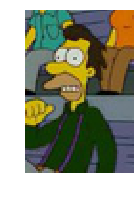

In [281]:
def eyeball_test_model(model):
    idx = random.randint(0, 100)
    test_image_names = get_images_from_directory(test_root_path)
    sample_file, sample_name = test_image_names[idx], test_image_names[idx].split('_')[:-1]
    path_file = os.path.join(test_root_path, sample_file)
    sample_image = imread(path_file)

    print("Label: {}".format('_'.join(sample_name)))
    
    #prediction
    pred = model.predict(sample_image[np.newaxis, :])
    print("PREDICTION: {}".format(lb.inverse_transform(pred)[0]))
 
    #showing the image
    plot_image(sample_image)

eyeball_test_model(model1)